In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path

import pytorch_lightning as pl
import torch
from pytorch_lightning import callbacks, seed_everything
from torch import nn

from nlp_assemblee.simple_trainer import LitModel, process_predictions
from nlp_assemblee.simple_visualisation import (
    calculate_metrics,
    plot_precision_recall_curve,
    plot_roc_curve,
)

In [3]:
seed_everything(42, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Global seed set to 42


'cuda'

In [4]:
BERT_TYPE = "camembert"
FEATURES = True
TEXT_VARS = ["intervention", "titre_complet", "profession"]
OPTIMIZER_TYPE = "Adam"
OPTIMIZER_KWARGS = {}
LR = 1e-4
LOSS = "CrossEntropyLoss"
BATCH_SIZE = 256

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.1,
    "patience": 5,
    "interval": "epoch",
    "frequency": 1,
    "strict": True,
    "monitor": "val_loss",
}

# SCHEDULER_KWARGS = {
#     "scheduler": "OneCycleLR",
#     "max_lr": 5e-3,
#     "pct_start": 0.3,
#     "epochs": 30,
#     "steps_per_epoch": 100,
#     "interval": "epoch",
#     "frequency": 1,
#     "strict": True
# }


LABEL_VAR = "label"
DATA_ROOT = "../../../data/"
NUM_WORKERS = 12
PREFETCH_FACTOR = 4
PIN_MEMORY = True

MAX_EPOCHS = 100
DEFAULT_ROOT_DIR = "../../../"
ACCELERATOR = "gpu"
CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss", mode="min", min_delta=0.01, check_finite=True, patience=10
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
]

RESULTS_PATH = "../../../results/textual_camembert/"


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 768),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 768),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 768),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(2, 256),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 768),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.01),
        )
        self.fc5 = nn.Sequential(
            nn.Linear(768, 512), nn.Dropout(0.2), nn.LeakyReLU(0.01), nn.Linear(512, 3)
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_complet = x["text"]["titre_complet"]
        profession = x["text"]["profession"]
        features = x["features"].float()

        x_ = self.fc1(intervention)
        y_ = self.fc2(titre_complet)
        z_ = self.fc3(profession)
        f_ = self.fc4(features)

        p_ = intervention + x_ + y_ + z_ + f_

        p_ = self.fc5(p_)

        return p_


NET = Net()

In [5]:
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": DATA_ROOT,
        "bert_type": BERT_TYPE,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    default_root_dir=DEFAULT_ROOT_DIR,
    callbacks=CALLBACKS,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(lit_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type       | Params
-------------------------------------------------
0  | classifier       | Net        | 5.3 M 
1  | classifier.fc1   | Sequential | 1.6 M 
2  | classifier.fc1.0 | Linear     | 787 K 
3  | classifier.fc1.1 | Dropout    | 0     
4  | classifier.fc1.2 | LeakyReLU  | 0     
5  | classifier.fc1.3 | Linear     | 787 K 
6  | classifier.fc1.4 | Dropout    | 0     
7  | classifier.fc1.5 | LeakyReLU  | 0     
8  | classifier.fc2   | Sequential | 1.6 M 
9  | classifier.fc2.0 | Linear     | 787 K 
10 | classifier.fc2.1 | Dropout    | 0     
11 | classifier.fc2.2 | LeakyReLU  | 0     
12 | classifier.fc2.3 | Linear     | 787 K 
13 | classifier.fc2.4 | Dropout    | 0     
14 | classifier.fc2.5 | LeakyReLU  | 0     
15 | classifier.fc3   | Sequential | 1.6 M 
16 | classifier.fc3.0 | Linear     | 787 K 
17 | classifier.fc3.1 | Dropout    | 0     
18 | classifier.fc3.2 | LeakyReLU  | 0     
19 | classifier.fc3.3 | Lin

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [7]:
trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at ../../../lightning_logs/version_39/checkpoints/epoch=90-step=63336.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../../lightning_logs/version_39/checkpoints/epoch=90-step=63336.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9729154706001282
        test_loss           0.0825287327170372
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0825287327170372, 'test_accuracy': 0.9729154706001282}]

In [8]:
preds = trainer.predict(ckpt_path="best")

Restoring states from the checkpoint path at ../../../lightning_logs/version_39/checkpoints/epoch=90-step=63336.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../../lightning_logs/version_39/checkpoints/epoch=90-step=63336.ckpt


Predicting: 696it [00:00, ?it/s]

In [9]:
results = process_predictions(preds)

In [10]:
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

In [11]:
metrics = calculate_metrics(results)
metrics

{'log_loss': 0.08252871164945258,
 'accuracy': 0.9729154823684741,
 'balanced_accuracy': 0.9718781386344086,
 'recall_weighted': 0.9729154823684741,
 'recall_micro': 0.9729154823684741,
 'recall_macro': 0.9718781386344086,
 'precision_weighted': 0.9729660755348282,
 'precision_micro': 0.9729154823684741,
 'precision_macro': 0.9710013736885871,
 'f1_score_weighted': 0.972899672414853,
 'f1_score_micro': 0.9729154823684741,
 'f1_score_macro': 0.9713987780505301,
 'AUC_weighted_ovr': 0.997215602222566,
 'AUC_macro_ovr': 0.9976484614719551,
 'AUC_weighted_ovo': 0.9977088347447753,
 'AUC_macro_ovo': 0.9978996843356076,
 'jaccard_weighted': 0.9472568832051224,
 'jaccard_micro': 0.9472594179610784,
 'jaccard_macro': 0.9444149679365424,
 'matthews_weighted': 0.9549500626264886,
 'hamming_loss': 0.027084517631525865}

In [75]:
logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

In [83]:
with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)

Micro-averaged One-vs-Rest ROC AUC score:
1.00
Macro-averaged One-vs-Rest ROC AUC score:
1.00


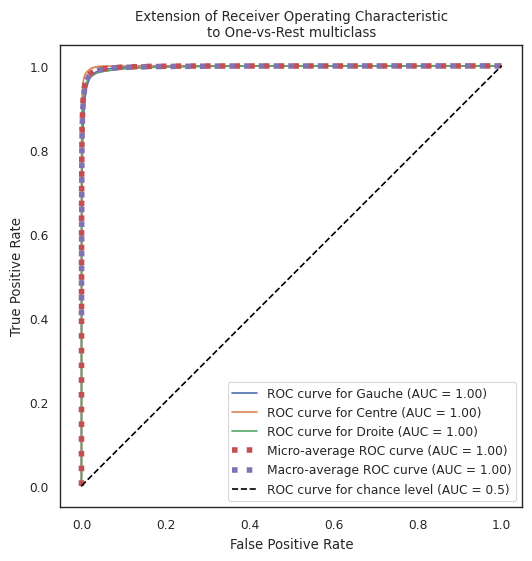

In [41]:
roc_fig = plot_roc_curve(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


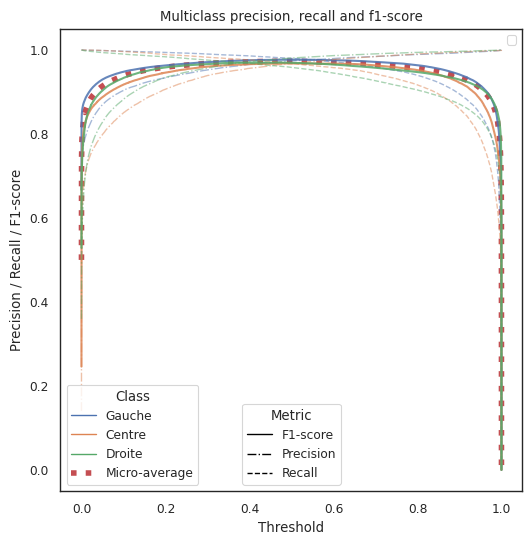

In [42]:
pr_fig = plot_precision_recall_curve(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

In [61]:
input_sample = {
    "text": {
        "intervention": torch.randn(32, 768),
        "titre_complet": torch.randn(32, 768),
        "profession": torch.randn(32, 768),
    },
    "features": torch.randn(32, 2),
}

lit_model.to_onnx(Path(RESULTS_PATH) / "textual_camembert.onnx", input_sample=input_sample)

KeyError: 'text'